In [9]:
!python -m venv tfenv
!.\tfenv\Scripts\activate  # Windows

In [1]:
import cv2
import glob
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, Subset

C:\Users\cagin\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
DB = "database/images/lung"
LABELS_DICT = {"NORMAL":0, 
               "COVID19":1,
              "PNEUMONIA":2}
INV_LABELS_DICT = {v: k for k, v in LABELS_DICT.items()}
os.listdir(DB)

['test', 'train']

In [3]:
test_url = DB+"/test"
train_url = DB+"/train"

In [4]:
def process_image(args):
    img_path, label = args
    image = cv2.imread(img_path)
    if image is None:
        return None
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image, (64, 64))
    image = image/255.0
    return image, LABELS_DICT[label]

In [5]:
def get_data_with_threads(path):
    start = time.time()
    tasks = []
    X = []
    y = []
    
    for p in os.listdir(path):
        labels = os.listdir(path+"/"+p)
        for label in labels:
            imgs_path = path+"/"+p+"/"+label+"/"
            for img in os.listdir(imgs_path):
                img_path = imgs_path+img
                tasks.append((img_path, label))
    
    with ThreadPoolExecutor() as executor:
        for result in executor.map(process_image, tasks):
            if result is not None:
                img, lbl = result
                X.append(img)
                y.append(lbl)
    
    end = time.time()
    return np.array(X), np.array(y), end-start
    

In [6]:
def get_data(path): #not used without thread
    start = time.time()
    X = []
    y = []
    
    for p in os.listdir(path):
        labels = os.listdir(path+"/"+p)
        for label in labels:
            imgs_path = path+"/"+p+"/"+label+"/"
            for img in os.listdir(imgs_path):
                img_path = imgs_path+img
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                image = cv2.resize(image, (64, 64))
                image = image/255.0
                X.append(image)
                y.append(LABELS_DICT[label])
    end = time.time()
    return np.array(X), np.array(y), end-start

In [7]:
def describe_dataset(class_path_1):
    data_info = []
    for p in os.listdir(class_path_1):
        labels = os.listdir(class_path_1+"/"+p)
        for class_x in labels:                
            class_path = class_path_1+"/"+ p +"/"+ class_x
            for image_name in os.listdir(class_path):
                image_path_whole = os.path.join(class_path, image_name)
                img = cv2.imread(image_path_whole)
                height, width, channels = img.shape if len(img.shape) == 3 else (img.shape[0], img.shape[1], 1)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img = cv2.resize(img, (100, 100))
                img = img / 255.0
                # Append information to the data_info list
                data_info.append({
                    'image': img,
                    'Class': class_x,
                    'Image Name': image_name,
                    'Height': height,
                    'Width': width,
                    'Channels': channels,
                })

    df = pd.DataFrame(data_info)
    return df

In [8]:
def class_distribution(labels):
    plt.figure(figsize=(8, 8))
    class_counts = pd.Series(labels).value_counts().sort_index()
    
    class_names = [INV_LABELS_DICT[label] for label in class_counts.index]
    plt.pie(class_counts, labels=class_names,
            autopct='%1.1f%%', startangle=90, textprops={'fontsize': 13})
    plt.title('Class Distribution', fontdict={"fontsize": 17})
    plt.show()

In [9]:
X, y, time_with_thread = get_data_with_threads(DB)

In [11]:
#_, _, time_without_thread = get_data(DB) # not used

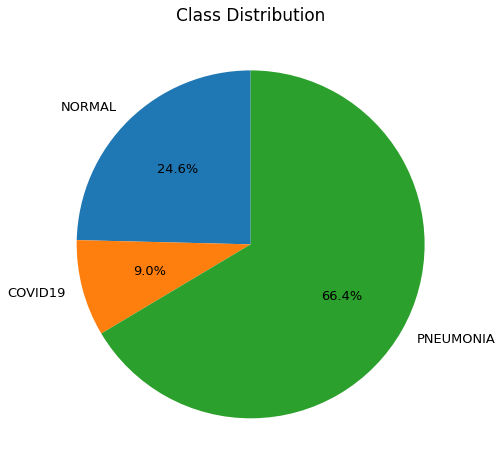

In [10]:
class_distribution(y)

In [13]:
len(X), len(y)

(6432, 6432)

In [14]:
plt.bar(x=["Without Thread", "With Thread"], height=[time_without_thread, time_with_thread], color="red")
plt.title("Time comparison for image preprocessing \n without VS with using thread")
plt.ylabel("Second")
plt.show()

NameError: name 'time_without_thread' is not defined

In [11]:
description_table = describe_dataset(DB)
description_table = description_table.sample(frac=1).reset_index(drop=True)
description_table

,image,Class,Image Name,Height,Width,Channels
0,"[[0.14901960784313725, 0.19215686274509805, 0....",PNEUMONIA,PNEUMONIA(1081).jpg,648,1016,3
1,"[[0.38823529411764707, 0.4235294117647059, 0.4...",PNEUMONIA,PNEUMONIA(3359).jpg,768,1096,3
2,"[[0.027450980392156862, 1.0, 0.031372549019607...",PNEUMONIA,PNEUMONIA(1093).jpg,1008,1440,3
3,"[[0.13725490196078433, 0.11372549019607843, 0....",PNEUMONIA,PNEUMONIA(1245).jpg,520,960,3
4,"[[0.08627450980392157, 0.13333333333333333, 0....",NORMAL,NORMAL(485).jpg,1017,1401,3
...,...,...,...,...,...,...
6427,"[[0.9921568627450981, 0.06666666666666667, 0.9...",PNEUMONIA,PNEUMONIA(1611).jpg,568,999,3
6428,"[[0.3843137254901961, 0.36470588235294116, 0.4...",NORMAL,NORMAL(1508).jpg,1260,1399,3
6429,"[[0.3686274509803922, 0.29411764705882354, 0.2...",PNEUMONIA,PNEUMONIA(295).jpg,440,952,3
6430,"[[0.35294117647058826, 0.3333333333333333, 0.3...",PNEUMONIA,PNEUMONIA(1934).jpg,632,1017,3


In [12]:
def plot_some_examples(X, y):
    classes = np.unique(y)
    fig, axes = plt.subplots(len(classes), 5, figsize=(15, 3 * len(classes)))

    for i, class_name in enumerate(classes):
        class_images = X[y == class_name][:5]
        for j in range(5):
            axes[i, j].imshow(class_images[j], cmap='gray')
            axes[i, j].set_title(f'{INV_LABELS_DICT[class_name]}')
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

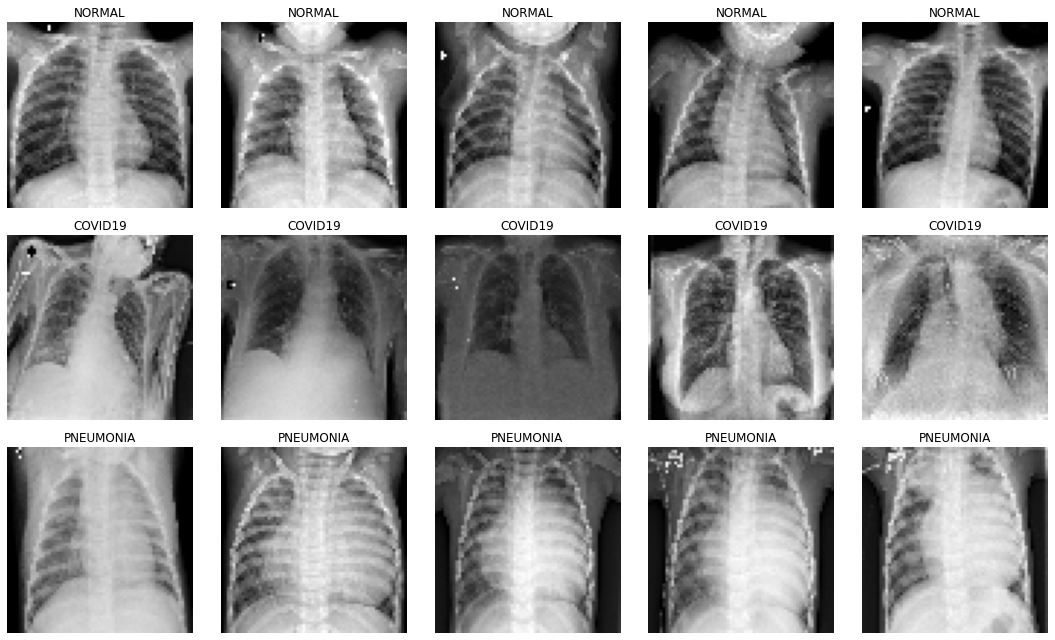

In [13]:
plot_some_examples(X,y)

In [51]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv_layer_1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2) 
        self.conv_layer_2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.linear_1 = nn.Linear(64*16*16, 128)
        self.linear_2 = nn.Linear(128, 3)
        self.dropout_1 = nn.Dropout(0.25)
        self.dropout_2 = nn.Dropout(0.1)
        
    def forward(self, x):
        x = self.conv_layer_1(x) #(B, 32, 64, 64)
        x = F.relu(x) 
        x = self.pool(x) #(B, 32, 32, 32)
        x = self.dropout_1(x)
        
        x = self.conv_layer_2(x) #(B, 64, 32, 32)
        x = F.relu(x)
        x = self.pool(x) #(B, 64, 16, 16)
        x = self.dropout_2(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.linear_1(x) #(B, 64*16*16, 128)
        x = F.relu(x)
        
        x = self.linear_2(x) #(B, 128, 3)
        x = F.softmax(x)
        return x


In [23]:
dataset = TensorDataset(X,y)
weights = 1.0/torch.bincount(y).float()
weights

tensor([0.0006, 0.0017, 0.0002])

In [27]:
def train_test(X, y, k_folds=5, epochs=5):
    folds = []
    predictions = []
    
    dataset = TensorDataset(X, y)
    kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    class_counts = torch.bincount(y)
    weights = 1.0 / class_counts.float()
    weights = weights / weights.sum()  # normalize to sum to 1
    print(f"Using class weights: {weights.tolist()}")

    for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
        print(f'\nFold {fold + 1}')

        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64)

        model = CNN()
        criterion = nn.CrossEntropyLoss(weight=weights)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        
        fold_results = []
        for epoch in range(epochs):
            model.train()
            running_loss = 0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
            
            print(f"Epoch {epoch+1} - Training Loss: {running_loss:.4f}")

            # Validation
            model.eval()
            correct, total = 0, 0
            all_preds = []
            with torch.no_grad():
                for images, labels in val_loader:
                    outputs = model(images)
                    preds = torch.argmax(outputs, dim=1)
                    all_preds.append(preds)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
            acc = 100 * correct / total
            fold_results.append(acc)
            print(f"Epoch {epoch+1} - Validation Accuracy: {acc:.2f}%")
        folds.append(f"Fold {fold}")
        predictions.append(np.mean(np.array(fold_results)))

        # 👀 Print class prediction distribution for debugging
        all_preds = torch.cat(all_preds)
        unique_classes, counts = torch.unique(all_preds, return_counts=True)
        print(f"Predicted class distribution: {dict(zip(unique_classes.tolist(), counts.tolist()))}")
    return folds, predictions

In [22]:
X = torch.tensor(X, dtype=torch.float32)
if X.ndim == 3:
    X = X.unsqueeze(1)  # (N, 64, 64) → (N, 1, 64, 64)
    
y = torch.tensor(y, dtype=torch.long)

In [24]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: torch.Size([6432, 1, 64, 64])
y shape: torch.Size([6432])


In [25]:
print(torch.bincount(y))

tensor([1583,  576, 4273])


In [52]:
folds, preds = train_test(X, y)

Using class weights: [0.24279330670833588, 0.6672601103782654, 0.08994659781455994]

Fold 1


<ipython-input-51-e61c05e76fb5>:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(x)


Epoch 1 - Training Loss: 63.7732
Epoch 1 - Validation Accuracy: 88.42%
Epoch 2 - Training Loss: 54.2140
Epoch 2 - Validation Accuracy: 90.75%
Epoch 3 - Training Loss: 52.3281
Epoch 3 - Validation Accuracy: 91.06%


KeyboardInterrupt: 

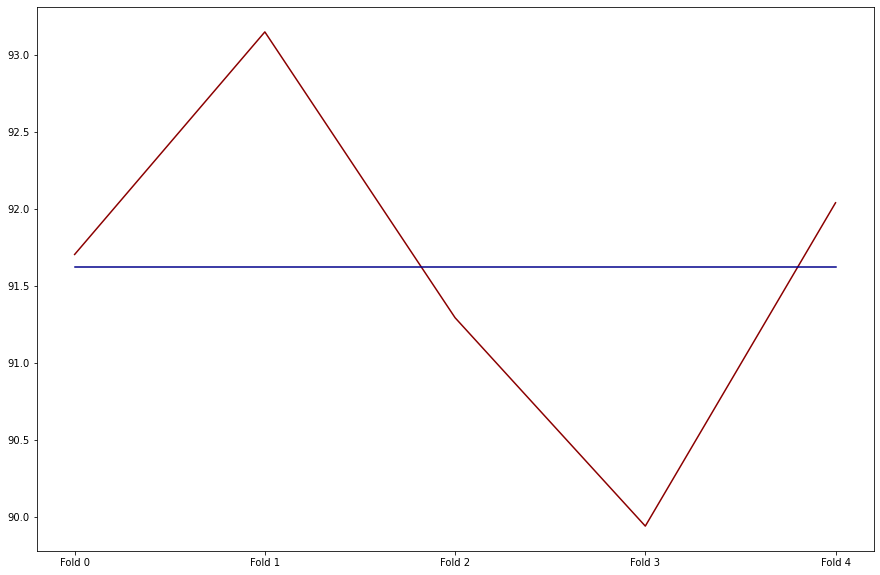

In [103]:
plt.figure(figsize=(15, 10))
plt.plot(folds, preds, color="darkred")
mean = np.mean(preds)
means = [mean for i in range(len(preds))]
plt.plot(folds, means, color="darkblue")
plt.show()